In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install music21
!pip install tensorflow
!pip install tqdm

In [ ]:
#Importing Libraries
import tensorflow
import numpy as np
import pandas as pd
from collections import Counter
import random
import IPython
from IPython.display import Image, Audio
import music21
from music21 import *
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import tensorflow.keras.backend as K
from tensorflow.keras.optimizers import Adamax
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
import sys
import warnings
warnings.filterwarnings("ignore")
warnings.simplefilter("ignore")
np.random.seed(42)

In [ ]:
import os
from music21 import converter

# Base directory containing all subfolders with MIDI files
base_dir = "/content/drive/MyDrive/SML_Music_final/SML_Dataset"

# List to store parsed MIDI fil
all_midis = []

# Traverse through all directories and subdirectories
for root, dirs, files in os.walk(base_dir):
    for file in files:
        if file.endswith(".mid"):  # Check if the file is a MIDI file
            file_path = os.path.join(root, file)
            try:
                print(f"Processing: {file_path}")  # Print the current file being processed
                midi = converter.parse(file_path)  # Parse the MIDI file
                all_midis.append(midi)  # Add the parsed MIDI to the list
                print(f"Successfully processed: {file}")  # Indicate successful processing
            except Exception as e:
                print(f"Error processing {file}: {e}")  # Handle and display errors

# Print the total number of processed files
print(f"Total MIDI files processed: {len(all_midis)}")


Processing: /content/drive/MyDrive/archive (3)/chopin/chpn_op25_e4.mid
Successfully processed: chpn_op25_e4.mid
Processing: /content/drive/MyDrive/archive (3)/chopin/chpn_op10_e12.mid
Successfully processed: chpn_op10_e12.mid
Processing: /content/drive/MyDrive/archive (3)/chopin/chpn-p14.mid
Successfully processed: chpn-p14.mid
Processing: /content/drive/MyDrive/archive (3)/chopin/chpn_op25_e1.mid
Successfully processed: chpn_op25_e1.mid
Processing: /content/drive/MyDrive/archive (3)/chopin/chpn-p13.mid
Successfully processed: chpn-p13.mid
Processing: /content/drive/MyDrive/archive (3)/chopin/chpn_op33_2.mid
Successfully processed: chpn_op33_2.mid
Processing: /content/drive/MyDrive/archive (3)/chopin/chpn_op23.mid
Successfully processed: chpn_op23.mid
Processing: /content/drive/MyDrive/archive (3)/chopin/chpn_op25_e2.mid
Successfully processed: chpn_op25_e2.mid
Processing: /content/drive/MyDrive/archive (3)/chopin/chpn_op7_1.mid
Successfully processed: chpn_op7_1.mid
Processing: /conte

In [ ]:
from tqdm import tqdm
from music21 import instrument, note, chord

def extract_notes(files):
    notes = []
    pick = None

    # Wrap files in tqdm for progress tracking
    for j in tqdm(files, desc="Processing MIDI files"):
        try:
            songs = instrument.partitionByInstrument(j)
            for part in songs.parts:
                pick = part.recurse()
                for element in pick:
                    if isinstance(element, note.Note):
                        notes.append(str(element.pitch))
                    elif isinstance(element, chord.Chord):
                        notes.append(".".join(str(n) for n in element.normalOrder))
        except Exception as e:
            print(f"Error processing file: {e}")

    return notes

# Getting the list of notes as Corpus
Corpus = extract_notes(all_midis)
print("Total notes in all the MIDIs in the dataset:", len(Corpus))


Processing MIDI files: 100%|██████████| 48/48 [00:10<00:00,  4.76it/s]

Total notes in all the MIDIs in the dataset: 57894


In [ ]:
# Load the Corpus from NumPy file
Corpus = np.load("/content/drive/MyDrive/SML_Music_final/corpus_notes.npy", allow_pickle=True).tolist()
print("Corpus loaded successfully from 'corpus_notes.npy'.")
print(f"Total notes in Corpus: {len(Corpus)}")


Corpus loaded successfully from 'corpus_notes.npy'.
Total notes in Corpus: 474988


In [ ]:
from music21 import stream, note, chord
from tqdm import tqdm
from IPython.display import display, Image

def show(music, output_path="output.png"):
    """Display the music snippet as an image using the musicxml.png backend."""
    try:
        # Write the music stream as a MusicXML-based PNG file
        output_path = music.write("musicxml.png")
        # Display the generated image
        display(Image(output_path))
    except Exception as e:
        print(f"Error displaying music: {e}")

def chords_n_notes(Snippet):
    """Convert a sequence of notes and chords into a music21 Stream."""
    Melody = []
    offset = 0  # Incremental offset for each note/chord

    # Wrap Snippet with tqdm for progress monitoring
    for i in tqdm(Snippet, desc="Building Melody Snippet"):
        try:
            # If it is a chord
            if "." in i or i.isdigit():
                chord_notes = i.split(".")  # Split chord into individual notes
                notes = [note.Note(int(j)) for j in chord_notes]
                chord_snip = chord.Chord(notes)
                chord_snip.offset = offset
                Melody.append(chord_snip)
            # If it is a note
            else:
                note_snip = note.Note(i)
                note_snip.offset = offset
                Melody.append(note_snip)

            # Increase offset so that notes do not overlap
            offset += 1

        except Exception as e:
            print(f"Error processing element: {i}, {e}")

    return stream.Stream(Melody)

# Process the first 100 elements of Corpus
Melody_Snippet = chords_n_notes(Corpus)  # Process only the first 100 elements
show(Melody_Snippet)


Building Melody Snippet: 100%|██████████| 57894/57894 [00:06<00:00, 9508.18it/s] 


KeyboardInterrupt: 

In [ ]:
count_num = Counter(Corpus)
print("Total unique notes in the Corpus:", len(count_num))


Total unique notes in the Corpus: 397


In [ ]:
Notes = list(count_num.keys())
Recurrence = list(count_num.values())
#Average recurrenc for a note in Corpus
def Average(lst):
    return sum(lst) / len(lst)
print("Average recurrenc for a note in Corpus:", Average(Recurrence))
print("Most frequent note in Corpus appeared:", max(Recurrence), "times")
print("Least frequent note in Corpus appeared:", min(Recurrence), "time")

Average recurrenc for a note in Corpus: 145.8287153652393
Most frequent note in Corpus appeared: 1627 times
Least frequent note in Corpus appeared: 1 time


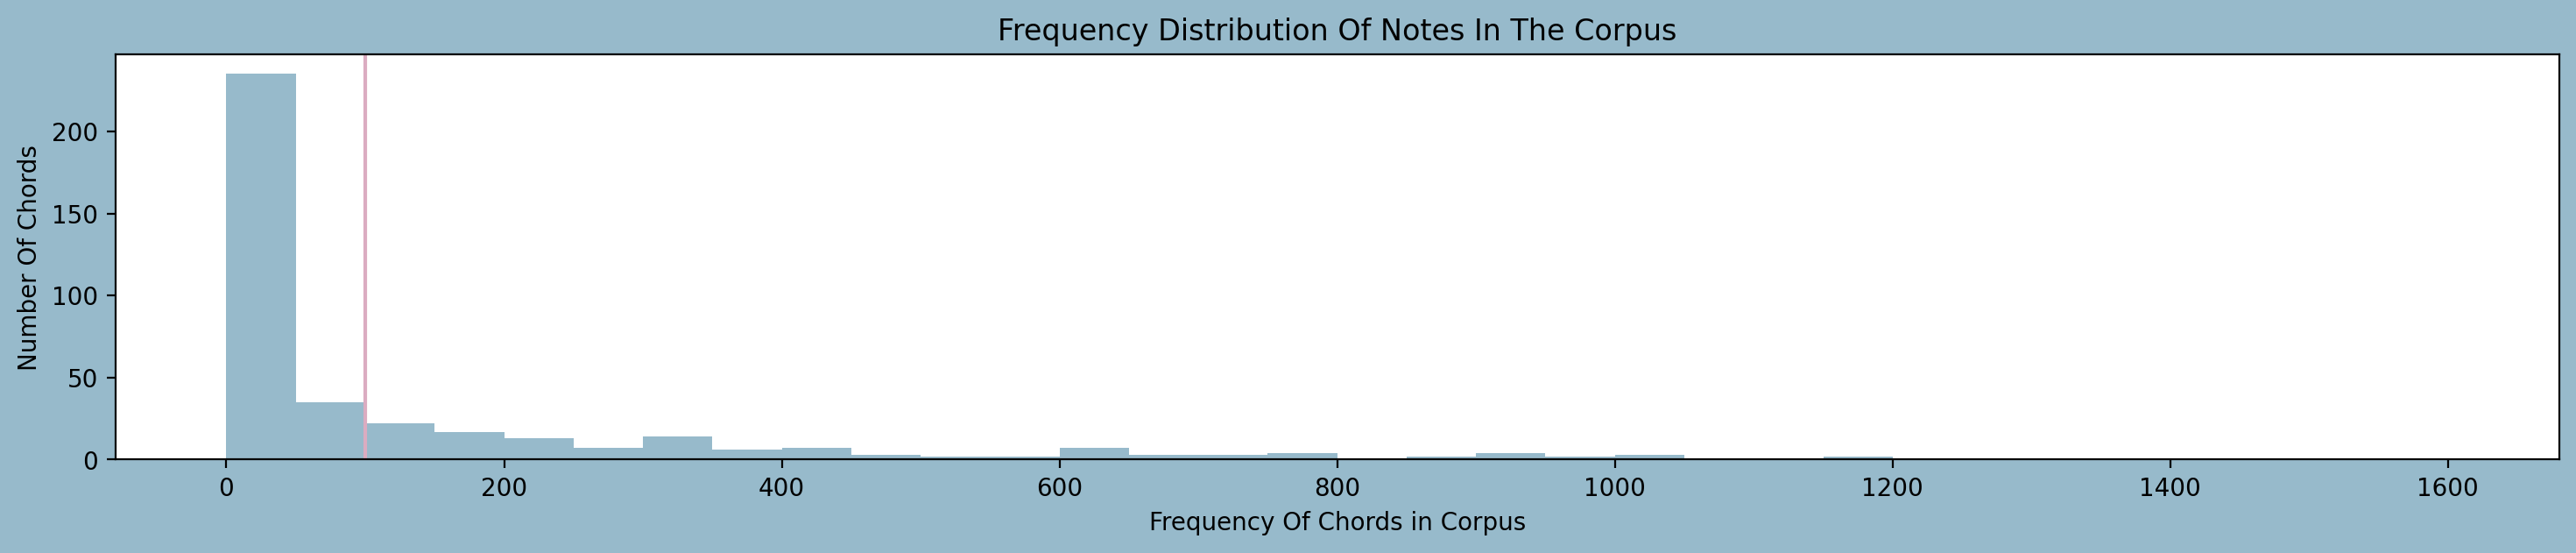

In [ ]:
plt.figure(figsize=(18,3),facecolor="#97BACB")
bins = np.arange(0,(max(Recurrence)), 50)
plt.hist(Recurrence, bins=bins, color="#97BACB")
plt.axvline(x=100,color="#DBACC1")
plt.title("Frequency Distribution Of Notes In The Corpus")
plt.xlabel("Frequency Of Chords in Corpus")
plt.ylabel("Number Of Chords")
plt.show()

In [ ]:
#Getting a list of rare chords
rare_note = []
for index, (key, value) in enumerate(count_num.items()):
    if value < 100:
        m =  key
        rare_note.append(m)

print("Total number of notes that occur less than 100 times:", len(rare_note))

Total number of notes that occur less than 100 times: 270


In [ ]:
from tqdm import tqdm

# Monitoring the process of removing rare notes
for element in tqdm(Corpus, desc="Removing rare notes from Corpus"):
    if element in rare_note:
        Corpus.remove(element)

print("Length of Corpus after eliminating the rare notes:", len(Corpus))


Removing rare notes from Corpus:  93%|█████████▎| 53747/57894 [00:02<00:00, 20896.36it/s]

Length of Corpus after eliminating the rare notes: 53746


In [ ]:
#Storing all the unique characters present in my corpus to bult a mapping dic.
symb = sorted(list(set(Corpus)))

L_corpus = len(Corpus) #length of corpus
L_symb = len(symb) #length of total unique characters

#Building dictionary to access the vocabulary from indices and vice versa
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

print("Total number of characters:", L_corpus)
print("Number of unique characters:", L_symb)

Total number of characters: 53746
Number of unique characters: 255


In [ ]:
#Splitting the Corpus in equal length of strings and output target
length = 40
features = []
targets = []
for i in range(0, L_corpus - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])


L_datapoints = len(targets)
print("Total number of sequences in the Corpus:", L_datapoints)

Total number of sequences in the Corpus: 53706


In [ ]:
# reshape X and normalize
X = (np.reshape(features, (L_datapoints, length, 1)))/ float(L_symb)
# one hot encode the output variable
y = tensorflow.keras.utils.to_categorical(targets)

In [ ]:
y.shape

(53706, 255)

In [ ]:
#Taking out a subset of data to be used as seed
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Initialize the Model
model = Sequential()

# Adding Bidirectional LSTM layers
model.add(Bidirectional(LSTM(512, return_sequences=True), input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.1))  # Dropout layer for regularization

model.add(Bidirectional(LSTM(256)))  # Second Bidirectional LSTM layer
model.add(Dense(256, activation='relu'))  # Dense layer with ReLU activation
model.add(Dropout(0.1))  # Dropout for regularization

# Output layer with softmax activation
model.add(Dense(y.shape[1], activation='softmax'))

# Compile the model
opt = Adamax(learning_rate=0.01)  # Using Adamax optimizer
model.compile(loss='categorical_crossentropy', optimizer=opt)

print(model.summary())

In [ ]:
history = model.fit(X_train, y_train, batch_size=256, epochs=50)

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load preprocessed data (ensure the file path is correct)
Corpus = np.load("/content/drive/MyDrive/SML_Music_final/corpus_notes.npy", allow_pickle=True).tolist()
print("Corpus loaded successfully from 'corpus_notes.npy'.")
print(f"Total notes in Corpus: {len(Corpus)}")

# Filter rare notes
from collections import Counter

count_num = Counter(Corpus)
rare_note = [note for note, count in count_num.items() if count < 100]
Corpus = [element for element in Corpus if element not in rare_note]
print("Length of Corpus after eliminating rare notes:", len(Corpus))

# Map notes to indices and vice versa
symb = sorted(list(set(Corpus)))
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

# Prepare sequences
length = 40
features = []
targets = []
for i in range(0, len(Corpus) - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

# Reshape features and one-hot encode targets
X = np.reshape(features, (len(features), length, 1)) / float(len(symb))
y = tf.keras.utils.to_categorical(targets)
print(f"Feature shape: {X.shape}, Target shape: {y.shape}")

# Split data into training and seed sets
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

# Path to the pre-trained model
pretrained_model_path = "/content/drive/MyDrive/SML_Music_final/model_50.keras"

# Load the pre-trained model
try:
    model = load_model(pretrained_model_path)
    print("Pre-trained model loaded successfully from:", pretrained_model_path)
except Exception as e:
    print(f"Error loading the model: {e}")
    raise

# Modify the output layer to match the new number of classes
new_output_units = y.shape[1]  # This should be the number of unique classes in the updated corpus

# Pop the last layer and add a new output layer with a unique name
model.pop()  # Remove the old output layer

# Add a new Dense output layer with a unique name
model.add(Dense(new_output_units, activation='softmax', name='new_output_layer'))

# Recompile the model
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

# Print the model summary to verify changes
print(model.summary())

# Train the model for 50 additional epochs
history = model.fit(X_train, y_train, batch_size=256, epochs=50)

# Save the updated model
updated_model_path = "/content/drive/MyDrive/SML_Music_final/model_100.keras"
model.save(updated_model_path)
print("Updated model saved to:", updated_model_path)

# Visualize training progress
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss Over Additional 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adamax
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import Dense

# Ensure reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Load preprocessed data (ensure the file path is correct)
Corpus = np.load("/content/drive/MyDrive/SML_Music_final/corpus_notes.npy", allow_pickle=True).tolist()
print("Corpus loaded successfully from 'corpus_notes.npy'.")
print(f"Total notes in Corpus: {len(Corpus)}")

# Filter rare notes
from collections import Counter

count_num = Counter(Corpus)
rare_note = [note for note, count in count_num.items() if count < 100]
Corpus = [element for element in Corpus if element not in rare_note]
print("Length of Corpus after eliminating rare notes:", len(Corpus))

# Map notes to indices and vice versa
symb = sorted(list(set(Corpus)))
mapping = dict((c, i) for i, c in enumerate(symb))
reverse_mapping = dict((i, c) for i, c in enumerate(symb))

# Prepare sequences
length = 40
features = []
targets = []
for i in range(0, len(Corpus) - length, 1):
    feature = Corpus[i:i + length]
    target = Corpus[i + length]
    features.append([mapping[j] for j in feature])
    targets.append(mapping[target])

# Reshape features and one-hot encode targets
X = np.reshape(features, (len(features), length, 1)) / float(len(symb))
y = tf.keras.utils.to_categorical(targets)
print(f"Feature shape: {X.shape}, Target shape: {y.shape}")

# Split data into training and seed sets
X_train, X_seed, y_train, y_seed = train_test_split(X, y, test_size=0.2, random_state=42)

# Path to the pre-trained model
pretrained_model_path = "/content/drive/MyDrive/SML_Music_final/model_100.keras"

# Load the pre-trained model
try:
    model = load_model(pretrained_model_path)
    print("Pre-trained model loaded successfully from:", pretrained_model_path)
except Exception as e:
    print(f"Error loading the model: {e}")
    raise

# Modify the output layer to match the new number of classes
new_output_units = y.shape[1]  # This should be the number of unique classes in the updated corpus

# Pop the last layer and add a new output layer with a unique name
model.pop()  # Remove the old output layer

# Add a new Dense output layer with a unique name
model.add(Dense(new_output_units, activation='softmax', name='new_output_layer'))

# Recompile the model
opt = Adamax(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=opt)

# Print the model summary to verify changes
print(model.summary())

initial_epoch = 100
epochs_to_train = 50

# Train the model
history = model.fit(
    X_train,
    y_train,
    batch_size=256,
    epochs=initial_epoch + epochs_to_train,
    initial_epoch=initial_epoch,  # Start from the 100th epoch
)

# Save the updated model
updated_model_path = "/content/drive/MyDrive/SML_Music_final/model_150.keras"
model.save(updated_model_path)
print("Updated model saved to:", updated_model_path)

# Visualize training progress
plt.plot(history.history['loss'], label='Loss')
plt.title('Training Loss Over Additional 50 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/SML_Music_final/corpus_notes.npy'